In [1]:
#!pip install xgboost
#!pip install catboost
#!pip install lime

In [2]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# !pip install interpret
# from interpret.blackbox import LimeTabular
# from interpret import show

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import graphviz


import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading Data Collected from the CSE-CIC-IDS2018 dataset

data1 = pd.read_csv("02-14-2018.csv")
data2 = pd.read_csv("02-15-2018.csv")
data3 = pd.read_csv("02-16-2018.csv")
#data4 = pd.read_csv("02-20-2018.csv")
data5 = pd.read_csv("02-21-2018.csv")
data6 = pd.read_csv("02-22-2018.csv")
data7 = pd.read_csv("02-23-2018.csv")
data8 = pd.read_csv("02-28-2018.csv")
data9 = pd.read_csv("03-01-2018.csv")
data0 = pd.read_csv("03-02-2018.csv")

In [4]:
data4 = pd.read_csv("02-20-2018.csv")
data4.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)

In [5]:
data4.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6,20/02/2018 08:34:07,888751,11,11,1249.0,1969.0,736.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,0,0,20/02/2018 08:33:22,112642816,3,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56300000.0,7.071068,56300000.0,56300000.0,Benign
2,0,0,20/02/2018 08:36:11,112642712,3,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56300000.0,18.384776,56300000.0,56300000.0,Benign
3,0,0,20/02/2018 08:39:00,112642648,3,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56300000.0,5.656854,56300000.0,56300000.0,Benign
4,0,0,20/02/2018 08:41:49,112642702,3,0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56300000.0,65.053824,56300000.0,56300000.0,Benign


In [6]:
%%time
#Pre-Processing Functions

def convert_data_types(df):
    # Filter out any rows where 'Dst Port' equals 'Dst Port' as it might indicate a duplicate header row
    df = df[df['Dst Port'] != 'Dst Port']

    # List of columns to convert to integer
    columns_to_int = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
                      'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
                      'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
                      'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
                      'Fwd Header Len', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'FIN Flag Cnt', 'SYN Flag Cnt',
                      'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
                      'Down/Up Ratio', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
                      'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
                      'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
                      'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Max', 'Idle Min']

    # List of columns to convert to float
    columns_to_float = ['Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Idle Mean', 'Idle Std', 'Active Mean', 'Active Std',
                        'Pkt Size Avg', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Bwd Pkt Len Mean',
                        'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
                        'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Mean',
                        'Bwd IAT Std', 'Fwd Pkts/s', 'Bwd Pkts/s']

    # Loop over each column in the 'columns_to_int' list and convert them to integer
    for column in columns_to_int:
        df[column] = df[column].astype(int)

    # Loop over each column in the 'columns_to_float' list and convert them to float
    for column in columns_to_float:
        df[column] = df[column].astype(float)

    return df


def clean_data(df):
    # Replace 'Infinity' and 'infinity' with np.inf, then replace np.inf and -np.inf with np.nan
    df.replace(["Infinity", "infinity", np.inf, -np.inf], np.nan, inplace=True)

    # Drop null values
    df.dropna(inplace=True)
    
    # Drop Timestamp
    df.drop(columns="Timestamp", inplace=True)
    
    # Encode the 'Label' feature as binary: 'Benign' or 'Malicious'
    df['Label'] = df['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'Malicious')
    
    return df


#Used Undersampling because Oversampling will cause overfitting Even if I use techniques like SMOTE I have a limited computational power .

def balance_data(df):
    # Create an instance of RandomUnderSampler
    rus = RandomUnderSampler()

    # Apply under-sampling, split data directly into features and target
    X_balanced, y_balanced = rus.fit_resample(df.drop("Label", axis=1), df["Label"])

    # Combine the balanced data back into a single DataFrame
    df_balanced = pd.concat([X_balanced, y_balanced], axis=1)

    return df_balanced

#from imblearn.combine import SMOTEENN
#def balance_data(df):


#    X=df.drop(["Label"], axis=1)
#    y=df["Label"]
    
    # Apply the SMOTEENN technique
#    smote_enn = SMOTEENN(random_state=0)
#    X_resampled, y_resampled = smote_enn.fit_resample(X, y)


    # Combine X_resampled and y_resampled back into a single DataFrame
#    df = pd.concat([X_resampled, y_resampled], axis=1)
#    del X, y,X_resampled, y_resampled
 #   print("After Balancing :")
  #  print (df.shape)
   # print(df['Label'].value_counts())
    #return df

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
datalist=[data1,data2,data3,data4,data5,data6,data7,data8,data9,data0]

for i in range(len(datalist)):
  print("########### Data ",i," is under pre-processing ....##########")
  print(datalist[i].shape)
  datalist[i] = convert_data_types(datalist[i])
  datalist[i] = clean_data(datalist[i])
  datalist[i] = balance_data(datalist[i])
  print(datalist[i].shape)

########### Data  0  is under pre-processing ....##########
(1048575, 80)
(761886, 79)
########### Data  1  is under pre-processing ....##########
(1048575, 80)
(104996, 79)
########### Data  2  is under pre-processing ....##########
(1048575, 80)
(893544, 79)
########### Data  3  is under pre-processing ....##########
(7948748, 80)
(1152382, 79)
########### Data  4  is under pre-processing ....##########
(1048575, 80)
(721666, 79)
########### Data  5  is under pre-processing ....##########
(1048575, 80)
(724, 79)
########### Data  6  is under pre-processing ....##########
(1048575, 80)
(1132, 79)
########### Data  7  is under pre-processing ....##########
(613104, 80)
(136472, 79)
########### Data  8  is under pre-processing ....##########
(331125, 80)
(184806, 79)
########### Data  9  is under pre-processing ....##########
(1048575, 80)
(572382, 79)


In [8]:
%%time
Full_Data = pd.concat(datalist, axis=0, ignore_index=True)

CPU times: total: 1.31 s
Wall time: 4.05 s


In [9]:
data3['Label'].value_counts()

DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: Label, dtype: int64

In [10]:
Full_Data.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,139,6,315973,2,1,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,53,17,1566,1,1,45,98,45,45,45.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,3389,6,3234779,10,7,1138,1581,677,0,113.8,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,80,6,91,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,53,17,1769,1,1,34,190,34,34,34.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [11]:
data3.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734,0.0,2624734,2624734,9058214.0,0.0,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0,0.0,0,0,0.0,0.0,0,0,Benign


In [12]:
Full_Data["Label"].value_counts()

Benign       2264995
Malicious    2264995
Name: Label, dtype: int64

In [13]:
Full_Data.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,139,6,315973,2,1,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,53,17,1566,1,1,45,98,45,45,45.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,3389,6,3234779,10,7,1138,1581,677,0,113.8,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,80,6,91,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,53,17,1769,1,1,34,190,34,34,34.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [27]:
%%time
# Concatination of the 10 datasets
Full_Data = pd.concat(datalist, axis=0, ignore_index=True)


# encode the target feature
Full_Data['Label'] = Full_Data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
print(Full_Data['Label'].unique())





[0 1]
CPU times: total: 5.55 s
Wall time: 8.01 s


In [28]:
# drop the constant columns 
variances = Full_Data.var(numeric_only=True)
constant_columns = variances[variances == 0].index
Full_Data = Full_Data.drop(constant_columns, axis=1)

In [37]:

%%time
#Drop duplicates
duplicates = set()
for i in range(0, len(Full_Data.columns)):
    col1 = Full_Data.columns[i]
    for j in range(i+1, len(Full_Data.columns)):
        col2 = Full_Data.columns[j]
        if(Full_Data[col1].equals(Full_Data[col2])):
            duplicates.add(col2)



CPU times: total: 4.08 s
Wall time: 4.49 s


In [38]:
print (duplicates)
Full_Data.drop(duplicates, axis=1, inplace=True)
print (Full_Data.shape)

set()
(4529990, 37)


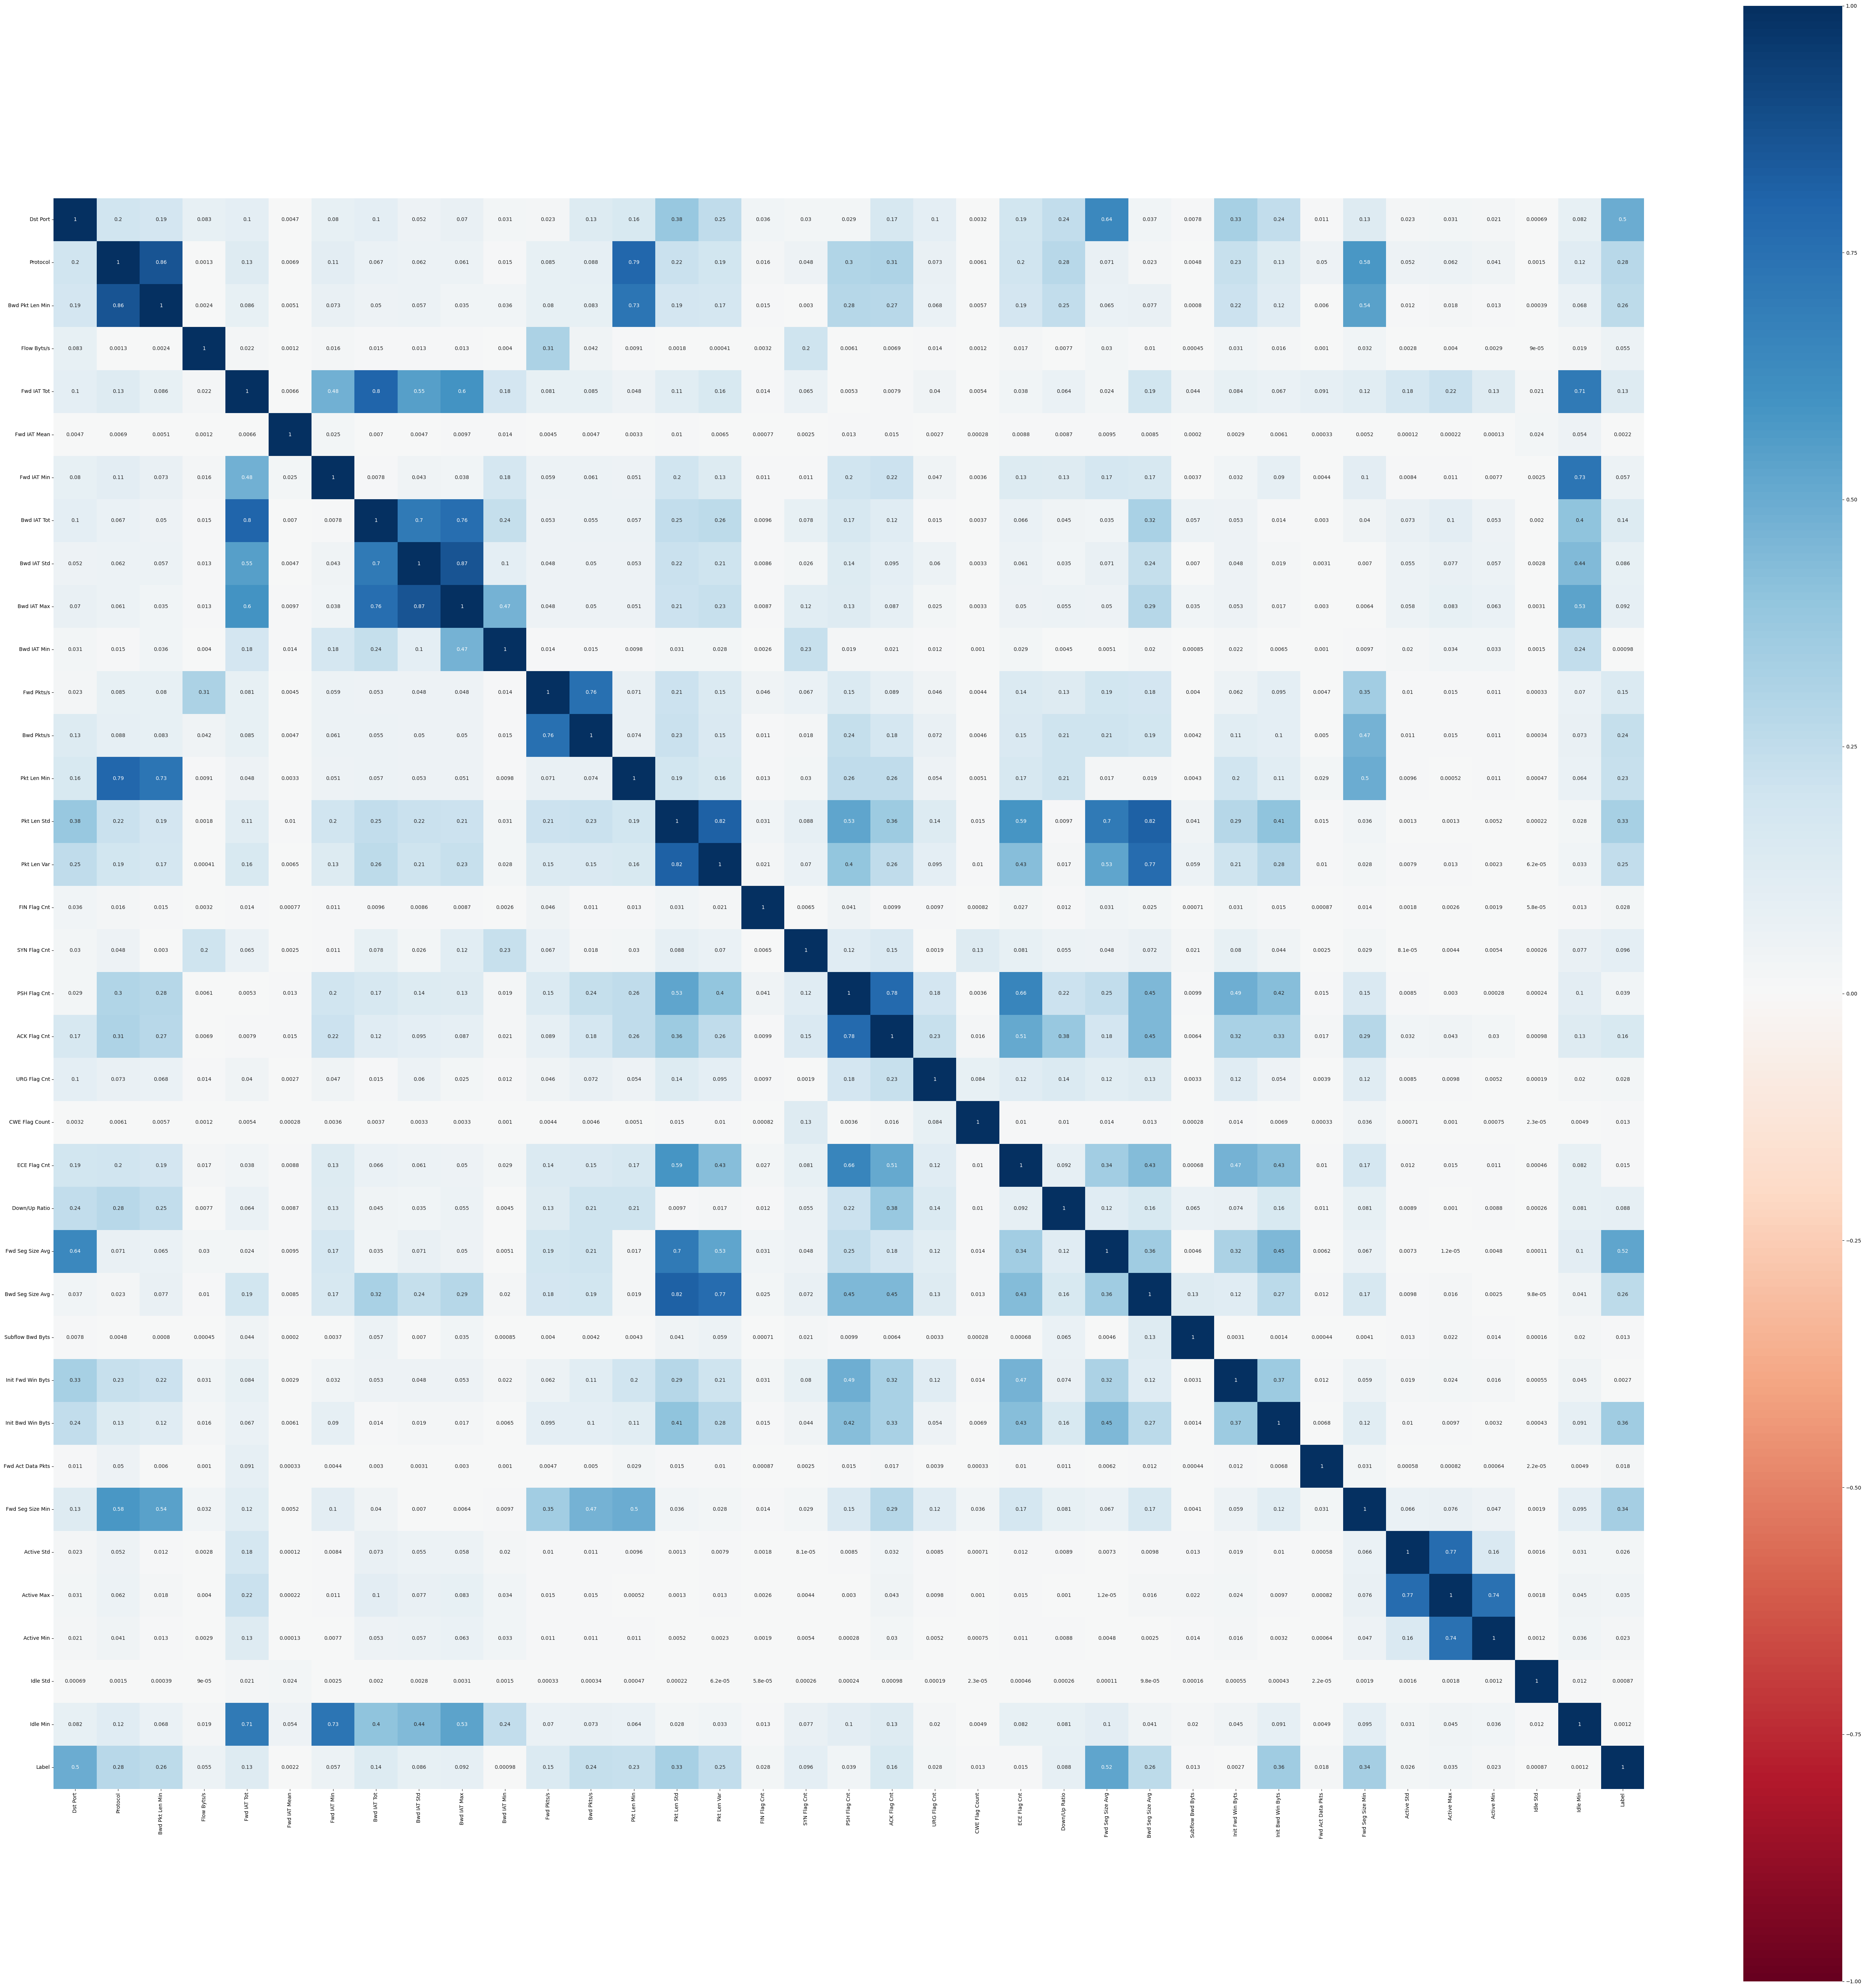

set()
0
(4529990, 37)


In [39]:
# Correlation matrix
corr = Full_Data.corr().abs()

# Heatmap
plt.figure(figsize=(70, 70))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True)
plt.show()

# Identify and remove highly correlated features
threshold = 0.90
correlated_col = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= threshold:
            colname = corr.columns[j]
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

# Drop highly correlated columns
Full_Data = Full_Data.drop(columns=correlated_col)
print(Full_Data.shape)

In [1]:
print(correlated_col)

NameError: name 'correlated_col' is not defined

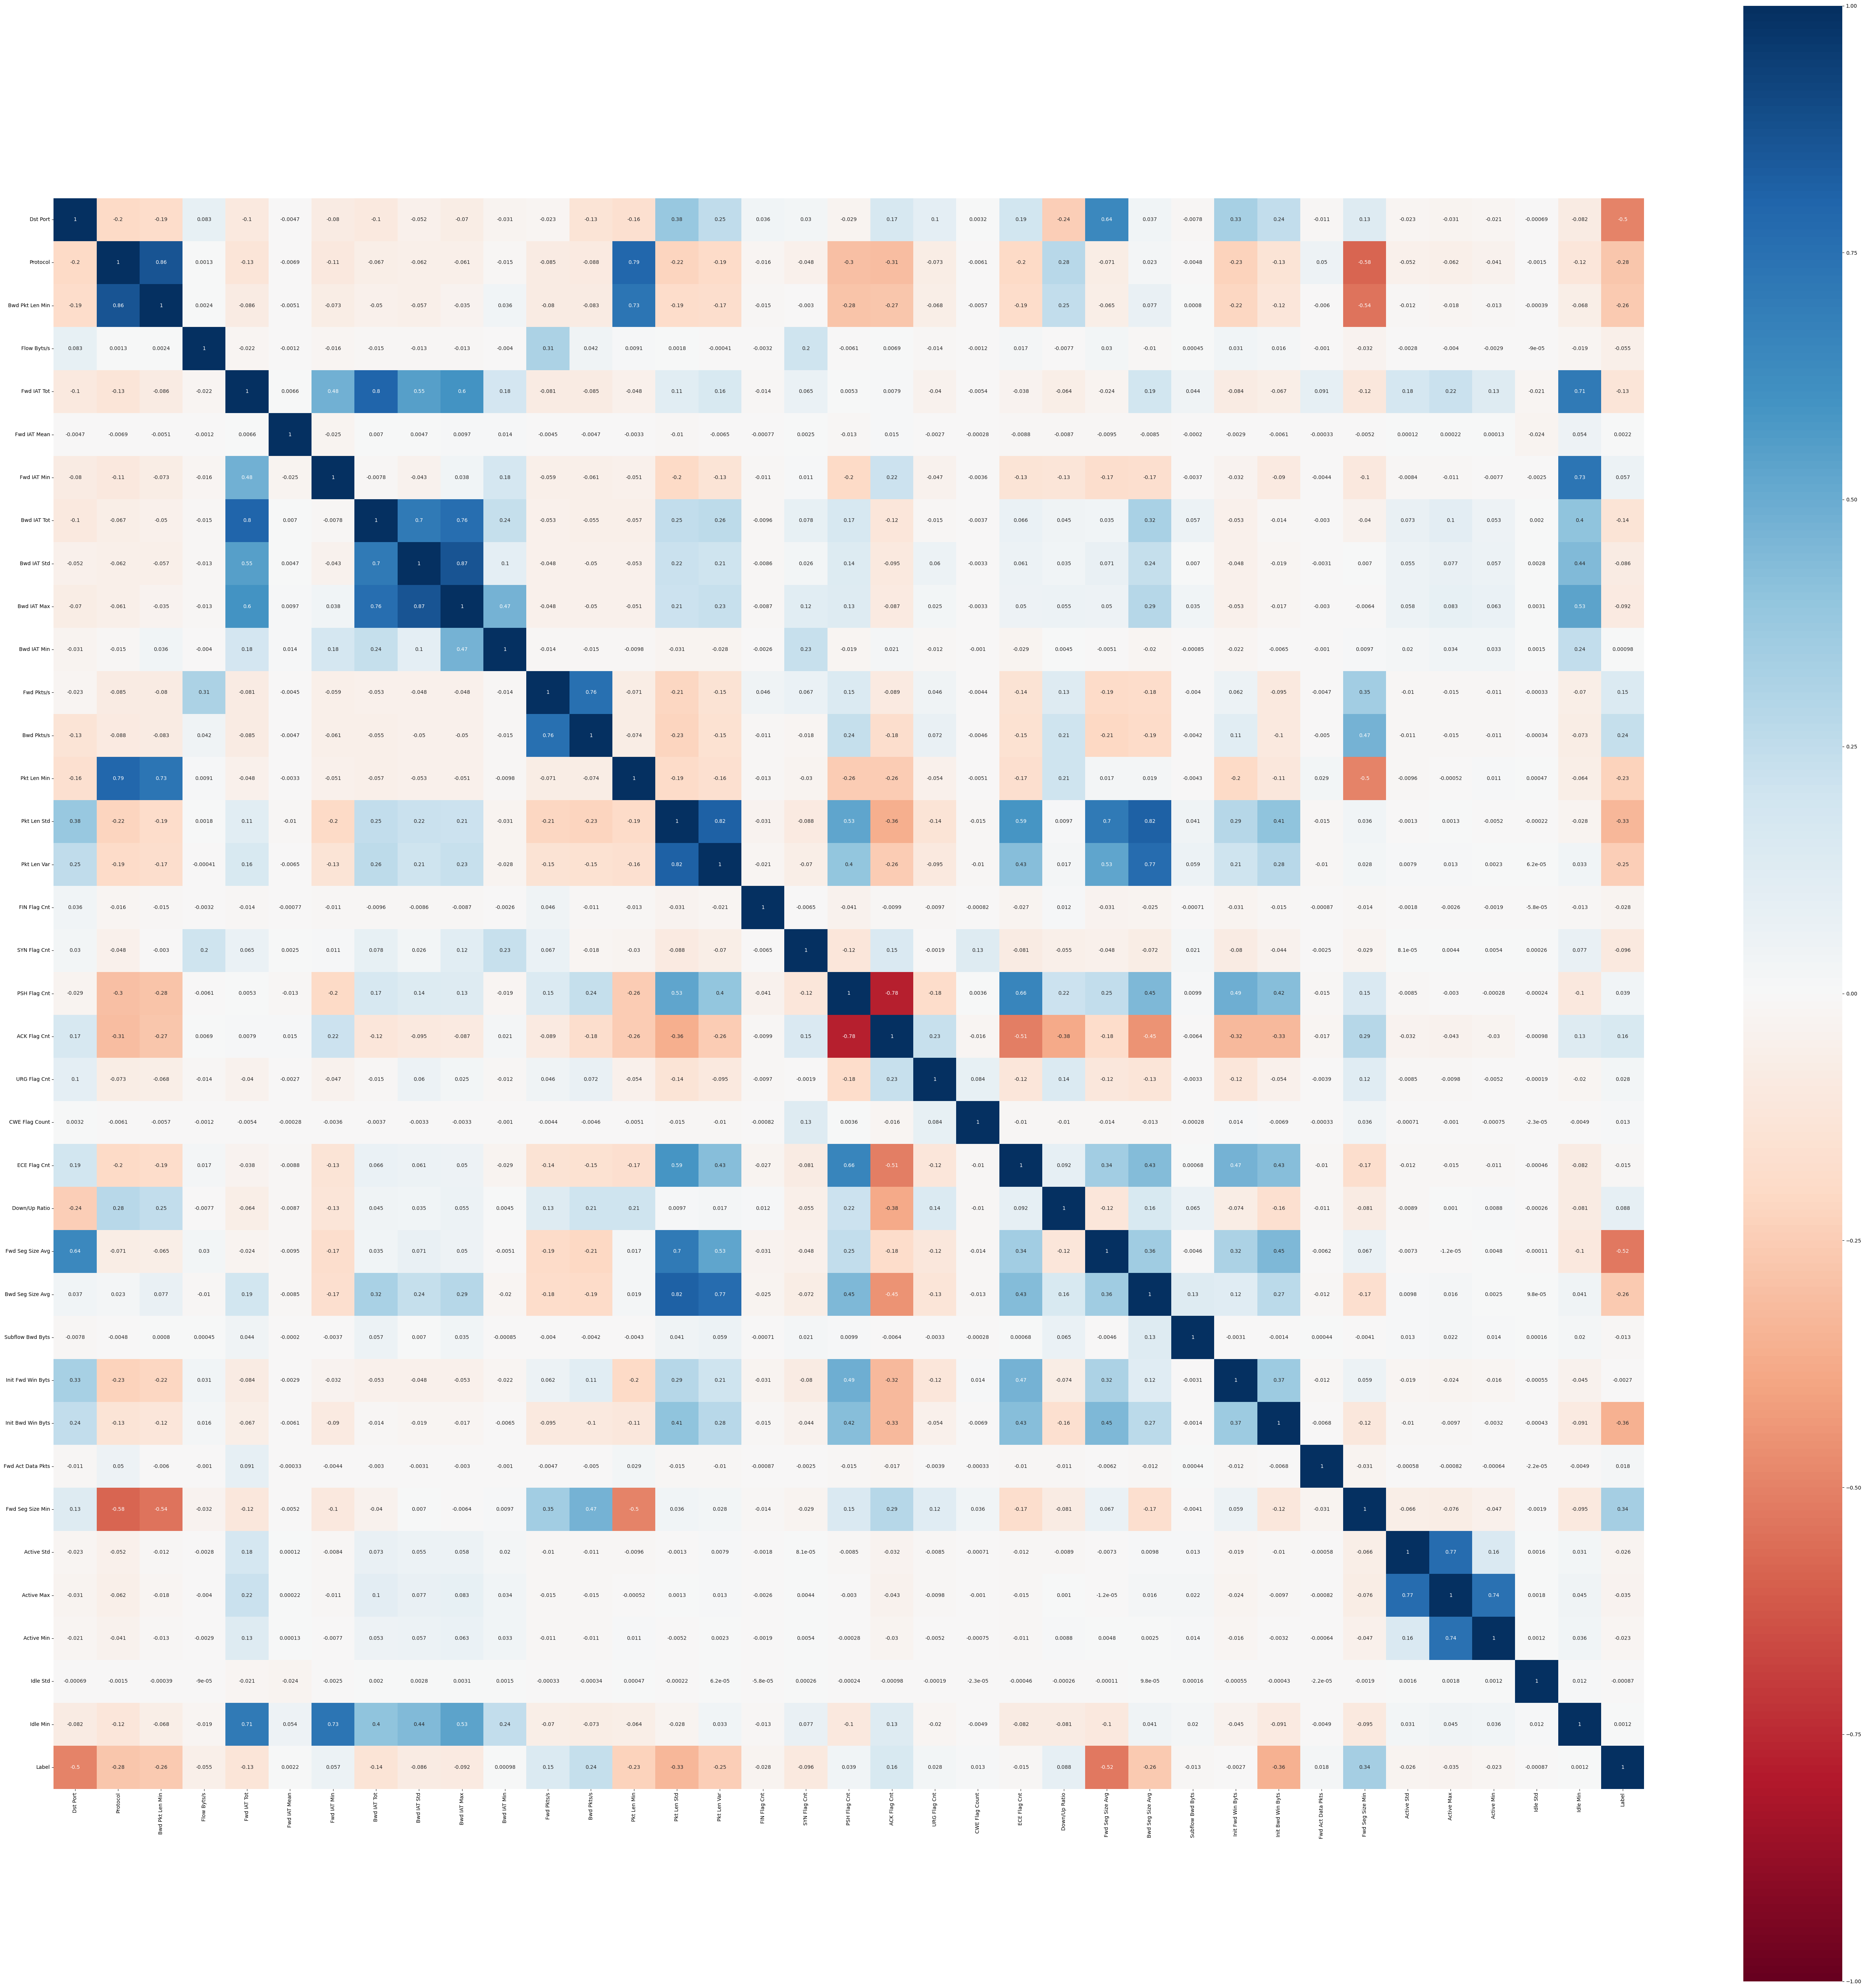

CPU times: total: 42.5 s
Wall time: 46.2 s


In [40]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = Full_Data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [3]:


#Full_Data.to_csv('Full_Dataset 2.csv', index=False)
Full_Data = pd.read_csv("Full_Dataset 2.csv")

In [4]:
%%time
# list numeric columns
# numeric_cols = network_data.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = Full_Data.select_dtypes(include=[np.number]).columns.tolist()
label_column = 'Label'
if label_column in numeric_cols:
    numeric_cols.remove(label_column)
print(numeric_cols)



['Dst Port', 'Protocol', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Min']
CPU times: total: 391 ms
Wall time: 425 ms


In [5]:
from sklearn.preprocessing import QuantileTransformer

# Create a QuantileTransformer object
qt = QuantileTransformer(output_distribution='uniform')

# Apply the transformer to the numeric columns of the dataframe
Full_Data[numeric_cols] = qt.fit_transform(Full_Data[numeric_cols])

In [6]:

%%time
X=Full_Data.drop(["Label"], axis=1)
y=Full_Data["Label"]

# split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state =42, shuffle=True)

# K-fold
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

CPU times: total: 4.67 s
Wall time: 5.5 s


In [56]:


%%time
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)



              precision    recall  f1-score   support

           0       0.96      0.96      0.96    227246
           1       0.96      0.96      0.96    225753

    accuracy                           0.96    452999
   macro avg       0.96      0.96      0.96    452999
weighted avg       0.96      0.96      0.96    452999

CPU times: total: 4min 35s
Wall time: 4min 49s


In [57]:
with open('modeldtc.pkl', 'wb') as file:
    pickle.dump(dtc, file)

In [58]:
%%time
# create a Extra Trees model
ett = ExtraTreesClassifier()

# predict
y_pred = cross_val_predict(ett, X, y, cv=kf)

print ("Extra Trees")
 # generate report
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

print("Performance Matrix:")
print(classification_report(y, y_pred))

Extra Trees
Confusion Matrix:
[[2207746   57249]
 [ 101587 2163408]]
Performance Matrix:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97   2264995
           1       0.97      0.96      0.96   2264995

    accuracy                           0.96   4529990
   macro avg       0.97      0.96      0.96   4529990
weighted avg       0.97      0.96      0.96   4529990

CPU times: total: 1h 20min 36s
Wall time: 1h 23min 44s


In [59]:
with open('ExtraTreesModel.pkl', 'wb') as file:
    pickle.dump(ett, file)

In [7]:
%%time
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()

# Train the SVM model on the training data
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    227246
           1       0.98      0.96      0.97    225753

    accuracy                           0.97    452999
   macro avg       0.97      0.97      0.97    452999
weighted avg       0.97      0.97      0.97    452999

CPU times: total: 44min 13s
Wall time: 50min 13s


In [8]:
with open('modelRF.pkl', 'wb') as file:
    pickle.dump(RF, file)